In [1]:
import os
import keras

from keras.preprocessing.image import ImageDataGenerator

keras.__version__

Using TensorFlow backend.


'2.3.1'

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
# Limits GPU-RAM usage
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
epochs = 100
batch_size = 5
target_width = 150
target_height = 150
target_size = (target_width, target_height)
target_shape = (target_width, target_height, 3) # 3 for color
base_dir = 'Course notebooks\paintings'

In [4]:
def get_generator(base_dir, folderName):
    directory = os.path.join(base_dir, folderName)
    return ImageDataGenerator(rescale=1./255).flow_from_directory(
        directory, 
        target_size, 
        batch_size= batch_size,
        shuffle=True,
        class_mode='sparse'
    )

In [5]:
train_gen = get_generator(base_dir, 'train')
test_gen = get_generator(base_dir, 'test')
validation_gen = get_generator(base_dir, 'validation')

Found 210 images belonging to 3 classes.
Found 30 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


In [6]:
numOfClasses = train_gen.num_classes

numOfTrainSamples = train_gen.n
numOfTestSamples = test_gen.n
numOfValSamples = validation_gen.n

In [7]:
# Define Conv model

In [8]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', 
                  include_top=False, 
                  input_shape= target_shape) # honestly, I'm not sure whether height or width comes first

In [9]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [10]:
block1_pool_width = 75
block1_pool_height = 75
block1_pool_area = block1_pool_width * block1_pool_height
block1_pool_no_of_filters = 64

block2_pool_width = 37
block2_pool_height = 37
block2_pool_area = block2_pool_width * block2_pool_height
block2_pool_no_of_filters = 128

block3_pool_width = 18
block3_pool_height = 18
block3_pool_area = block3_pool_width * block3_pool_height
block3_pool_no_of_filters = 256

block4_pool_width = 9
block4_pool_height = 9
block4_pool_area = block4_pool_width * block4_pool_height
block4_pool_no_of_filters = 512

## Following not used, but included for completeness and your own possible experiments
block5_pool_width = 4
block5_pool_height = 4
block5_pool_area = block5_pool_width * block5_pool_height
block5_pool_no_of_filters = 512

In [11]:
from keras import Model

intermediate_layer_model = Model(inputs=conv_base.input, 
                                 outputs=conv_base.get_layer('block4_pool').output)
no_of_filters_left = 10

In [12]:
from keras.utils.np_utils import to_categorical

def extract_features(generator, sample_count):
    features = np.zeros(shape=(sample_count, block4_pool_width, block4_pool_height, block4_pool_no_of_filters))
    labels = np.zeros(shape=(sample_count))
    
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = intermediate_layer_model.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break

    ### Now throwing away most of the features (= results of features)
    features = features[:,:,:,0:no_of_filters_left]
    ### convert labels 0, 1, and 2 to [1,0,0], [0,1,0] and [0,0,1] 
    labels = to_categorical(labels)
    return features, labels

In [13]:
import numpy as np

train_features, train_labels = extract_features(train_gen, numOfTrainSamples)

validation_features, validation_labels = extract_features(validation_gen, numOfValSamples)

test_features, test_labels = extract_features(test_gen, numOfTestSamples)

In [14]:
train_features = np.reshape(train_features, (numOfTrainSamples, block4_pool_area * no_of_filters_left))
validation_features = np.reshape(validation_features, (numOfValSamples, block4_pool_area * no_of_filters_left))
test_features = np.reshape(test_features, (numOfTestSamples, block4_pool_area * no_of_filters_left))

In [15]:
# Define Dense model

In [16]:
from keras import models
from keras.layers import InputLayer, Flatten, Dense, Dropout

def get_model(shape, nClasses):
    return keras.Sequential([
        InputLayer(input_shape=shape),
        #Flatten(),    ### Need to flatten if dense NN else if ConvNet no need to flatten.
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(8, activation='relu'),
        Dense(nClasses, activation='sigmoid'),
    ],)

In [17]:
input_shape = (block4_pool_area * no_of_filters_left, ) # needs the ", " in the end for the InputLayer in the model
model = get_model(input_shape, numOfClasses)

In [18]:
# train model

In [19]:
from keras import optimizers

model.compile(loss="binary_crossentropy", optimizer=optimizers.RMSprop(lr=2e-5), metrics=["acc"])

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                25952     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 27        
Total params: 26,243
Trainable params: 26,243
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model.fit(
    train_features, 
    train_labels,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(validation_features, validation_labels))

Train on 210 samples, validate on 60 samples
Epoch 1/100
210/210 [==============================] - 0s 610us/step - loss: 1.7025 - acc: 0.4111 - val_loss: 1.3272 - val_acc: 0.4278
Epoch 2/100
210/210 [==============================] - 0s 167us/step - loss: 1.5822 - acc: 0.4492 - val_loss: 1.2356 - val_acc: 0.4389
Epoch 3/100
210/210 [==============================] - 0s 167us/step - loss: 1.3902 - acc: 0.4603 - val_loss: 1.1489 - val_acc: 0.4556
Epoch 4/100
210/210 [==============================] - 0s 162us/step - loss: 1.4443 - acc: 0.4365 - val_loss: 1.0758 - val_acc: 0.4722
Epoch 5/100
210/210 [==============================] - 0s 171us/step - loss: 1.3204 - acc: 0.4778 - val_loss: 1.0069 - val_acc: 0.4778
Epoch 6/100
210/210 [==============================] - 0s 171us/step - loss: 1.2109 - acc: 0.4968 - val_loss: 0.9517 - val_acc: 0.4722
Epoch 7/100
210/210 [==============================] - 0s 181us/step - loss: 1.2345 - acc: 0.4841 - val_loss: 0.9009 - val_acc: 0.4944
Epoch 8/10

Epoch 61/100
210/210 [==============================] - 0s 162us/step - loss: 0.4786 - acc: 0.7286 - val_loss: 0.3827 - val_acc: 0.7611
Epoch 62/100
210/210 [==============================] - 0s 157us/step - loss: 0.4845 - acc: 0.7444 - val_loss: 0.3802 - val_acc: 0.7667
Epoch 63/100
210/210 [==============================] - 0s 162us/step - loss: 0.4672 - acc: 0.7524 - val_loss: 0.3781 - val_acc: 0.7667
Epoch 64/100
210/210 [==============================] - 0s 167us/step - loss: 0.4735 - acc: 0.7444 - val_loss: 0.3759 - val_acc: 0.7722
Epoch 65/100
210/210 [==============================] - 0s 176us/step - loss: 0.4557 - acc: 0.7683 - val_loss: 0.3735 - val_acc: 0.7722
Epoch 66/100
210/210 [==============================] - 0s 171us/step - loss: 0.4588 - acc: 0.7508 - val_loss: 0.3717 - val_acc: 0.7667
Epoch 67/100
210/210 [==============================] - 0s 167us/step - loss: 0.4900 - acc: 0.7635 - val_loss: 0.3697 - val_acc: 0.7667
Epoch 68/100
210/210 [==========================

In [22]:
#model.save('baseline.h5')

In [23]:
# validation

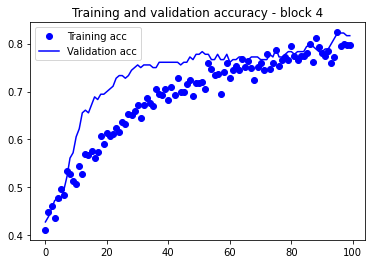

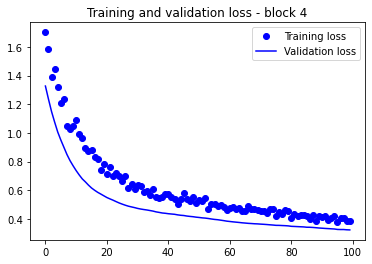

In [24]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy - block 4')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss - block 4')
plt.legend()

plt.show()